# Implementing ARI

## ACTION 1: Importing libraries and define static variables

In [1]:
#pip3 install matplotlib pandas sklearn statistics sklearn_relief
import os
import numpy as np
from math import *
from random import randint
# FOR PLOT
from matplotlib import pyplot

# FOR CHI-SQUARE - MUTUAL INFORMATION - RELIEF
import sklearn_relief as relief

# FOR CROSS FOLD VALIDATION
from sklearn.model_selection import StratifiedKFold, KFold

# FOR TESTING ON LOGISTIC REGRESSION
from sklearn.metrics import accuracy_score

from statistics import mean

# where all utilities are defined
import utils
from utils import *

## ACTION 2: Defining binary functions in functions.py
## ACTION 3: Dataset generation, pair generation and sampling in data_generation.py
## ACTION 4: Defining utilities for chi2 and mutual information in ch2_mi.py
## ACTION 5: Defining baseline logistic regression in baseline.py
## ACTION 6: Defining ARI in ari.py
## ACTION 7: Function to validate ARI stability wrt sample size - order relevance¶

In [2]:
def display_score_latex(dimension,row_name,scores_means,scores_std):
    latex_line=""
    for i in range(dimension):
        #latex_line+=" & "+str(round(scores_means[i],2))+"-"+str(round(scores_std[i],2))
        latex_line+=" & "+str(round(scores_means[i],2))
    print(row_name+latex_line+"\\\\")
    return True

def get_ari(dataset,dimension,sample_size):  #return a list of score per feature
    list_of_attributes=[]
    for i in range(dimension):   # index of attributes
        list_of_attributes.append(i)    
    ari_scores = [0]*dimension   # ari is all 0 to start with
    list_of_pairs = all_pairs(dataset)
    ari_scores = select_features_ars(dimension,list_of_attributes,dataset,list_of_pairs)
    return ari_scores

## ACTION 8: Validate ARI stability

In [3]:
def validate_stability(dimension,categorical_range,f,number_of_test,sample_size_list):
    for sample_size in sample_size_list:
        #mean_ari_scores = [0]*dimension
        feature_score_list=[]
        for i in range(dimension): #create a list of list of scores per feature
            feature_score_list.append([])
        for u in range(number_of_test):
            create_categorical_dataset(filename,f,dimension,sample_size,categorical_range)
            dataset, X, y, dimension = load_dataset(filename)
            ari_scores = get_ari(dataset,dimension,sample_size)
            for j in range(dimension): #accumulate the scores
                #mean_ari_scores[j]+=ari_scores[j]
                feature_score_list[j].append(ari_scores[j])
        ari_scores_means = [mean(feature_score_list[j]) for j in range(dimension)]
        ari_scores_std  = [np.array(feature_score_list[j]).std() for j in range(dimension)]
        display_score_latex(dimension,str(sample_size),ari_scores_means,ari_scores_std)
    return

'''FOR ARTIFICIAL DATASET

dimension = 15
categorical_range = 2 #1 means binary - range of values for feature

size_of_X=int(pow((categorical_range+1),dimension))

number_of_test = 10
sample_size_list = [300,400,500,1000,10000]
sample_size_list = [2000,5000]

filename=DATASET_GENERAL
print("dimension:",dimension, "- size of X:",size_of_X, " - number of test:",number_of_test) 

list_of_functions=[g1_array,g2_array,g3_array,g4_array,g5_array,g6_array,g7_array,g8_array]
list_of_functions=[g6_array,g7_array,g8_array]
for f in list_of_functions:
    print("function:",str(f))
    validate_stability(dimension,categorical_range,f,number_of_test,sample_size_list)    
'''

'FOR ARTIFICIAL DATASET\n\ndimension = 15\ncategorical_range = 2 #1 means binary - range of values for feature\n\nsize_of_X=int(pow((categorical_range+1),dimension))\n\nnumber_of_test = 10\nsample_size_list = [300,400,500,1000,10000]\nsample_size_list = [2000,5000]\n\nfilename=DATASET_GENERAL\nprint("dimension:",dimension, "- size of X:",size_of_X, " - number of test:",number_of_test) \n\nlist_of_functions=[g1_array,g2_array,g3_array,g4_array,g5_array,g6_array,g7_array,g8_array]\nlist_of_functions=[g6_array,g7_array,g8_array]\nfor f in list_of_functions:\n    print("function:",str(f))\n    validate_stability(dimension,categorical_range,f,number_of_test,sample_size_list)    \n'

## ACTION 9: Function to compare ARI - chi-square - mutual information - relief

In [4]:
def compare_score_on_dataset(filename,number_of_test,sample_ratio):
    dataset, X, y, dimension = load_dataset(filename)
    #INFO
    dataset_size=dataset.shape[0]
    print("****INFORMATION ON INITIAL DATA *******")
    print("dataset:",filename,"size:",dataset_size,"dimension:",dimension)

    #list of attribute as indices: 0, 1, ...
    list_of_attributes=[]
    attribute_names=[]
    for i in range(dimension):
        list_of_attributes.append(i)
        attribute_names.append("a"+str(i+1))
    #print(attribute_names)
    
    sample_size = int(dataset_size*sample_ratio)
    print(sample_size)
    mean_ari_scores    = [0]*dimension
    mean_chi_scores    = [0]*dimension
    mean_mut_scores    = [0]*dimension
    mean_relief_scores = [0]*dimension
    #print(sample_size)

    for u in range(number_of_test):
        sample_set = generate_sample_set(dataset,sample_size)
        list_of_pairs = all_pairs(sample_set)
        #print(len(list_of_pairs))
        ari_scores = select_features_ars(dimension,list_of_attributes,sample_set,list_of_pairs)
        #print(ars_scores)
# NOT SURE WE TEST ON THE SAME SET BECAUSE OF TEST_SIZE PARAM
        X_train_enc, y_train_enc, X_test_enc=prepare_all(X, y, test_size=sample_ratio, random_state=1)
        X_train_chi, X_test_chi, fs_chi = select_all_features_chi2(X_train_enc, y_train_enc, X_test_enc)
        X_train_mut, X_test_mut, fs_mut = select_all_features_mutual(X_train_enc, y_train_enc, X_test_enc)
    
    # RELIEF
        relief_scores = relief.Relief(n_features=dimension) # we check all attributes
        my_transformed_matrix = relief_scores.fit_transform(X_train_enc,y_train_enc)

# NORMALIZATION FACTORS - All scores are normalized +0.001 to avoid division by 0
        Z_ari    = sum(ari_scores) + 0.001  #WE SHOULD TAKE INTO ACCOUNT THE VALUE 2 (meaningless)
        Z_chi    = sum(fs_chi.scores_) + 0.001
        Z_mi     = sum(fs_mut.scores_) + 0.001
        Z_relief = sum(relief_scores.w_) + 0.001
        
#UPDATE MEAN SCORES BY ADDING NORMALIZED SCORES IN [0,1]  
        for j in range(dimension):
            if ari_scores[j]!=2:
                mean_ari_scores[j]   += ari_scores[j]/(Z_ari)  # adding 2 is meaningless !!!!
            mean_chi_scores[j]   += fs_chi.scores_[j]/(Z_chi)
            mean_mut_scores[j]   += fs_mut.scores_[j]/(Z_mi)
            mean_relief_scores[j]+= relief_scores.w_[j]/(Z_relief)

    mean_ari_scores    = [a*(1/number_of_test) for a in mean_ari_scores] # NOT SURE THIS CORRECT NOW
    mean_chi_scores    = [a*(1/number_of_test) for a in mean_chi_scores]
    mean_mut_scores    = [a*(1/number_of_test) for a in mean_mut_scores]
    mean_relief_scores = [a*(1/number_of_test) for a in mean_relief_scores]
    
    ari_scores_std  = [np.array(mean_ari_scores[j]).std() for j in range(dimension)]
    chi_scores_std  = [np.array(mean_chi_scores[j]).std() for j in range(dimension)]
    mut_scores_std  = [np.array(mean_mut_scores[j]).std() for j in range(dimension)]
    relief_scores_std  = [np.array(mean_relief_scores[j]).std() for j in range(dimension)]

    pyplot.title("ARI")
    pyplot.bar(attribute_names, mean_ari_scores)
    pyplot.show()

    pyplot.title("CHI-SQUARE")
    pyplot.bar(attribute_names, mean_chi_scores)
    pyplot.show()

    pyplot.title("MUTUAL INFORMATION")
    pyplot.bar(attribute_names, mean_mut_scores)
    pyplot.show()

    pyplot.title("RELIEF")
    pyplot.bar(attribute_names, mean_relief_scores)
    pyplot.show()
# PREPARE FOR LATEX
    display_score_latex(dimension,"   ari",mean_ari_scores,ari_scores_std)
    display_score_latex(dimension,"  chi2",mean_chi_scores,chi_scores_std)
    display_score_latex(dimension,"    mi",mean_mut_scores,mut_scores_std)
    display_score_latex(dimension,"relief",mean_relief_scores,relief_scores_std)
    
    return True

## ACTION 10: Comparing feature score methods values

6-primary-tumor.data-no_missing.csv
****INFORMATION ON INITIAL DATA *******
dataset: datasets-tested/6-primary-tumor.data-no_missing.csv size: 132 dimension: 17
105


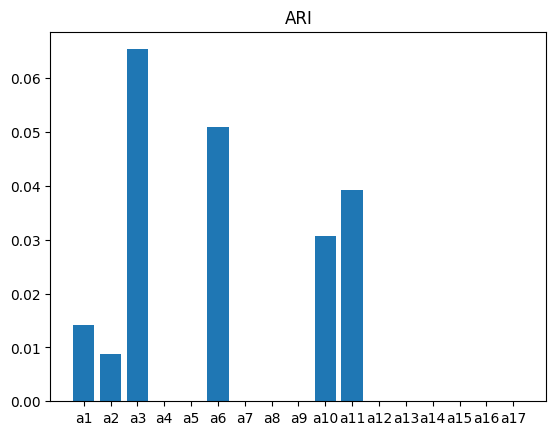

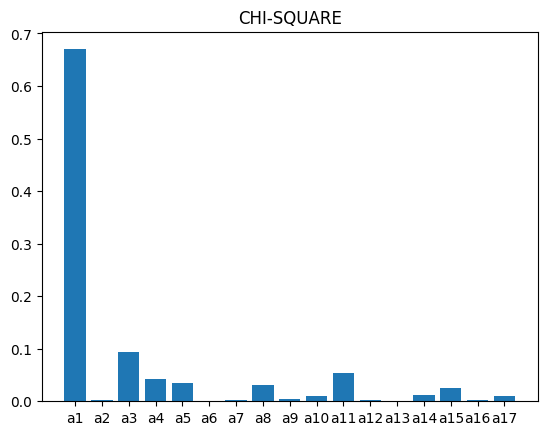

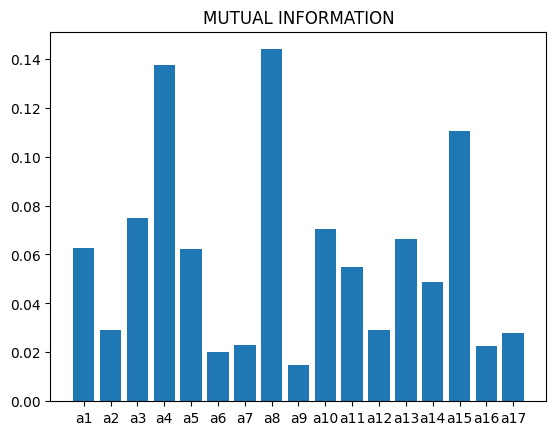

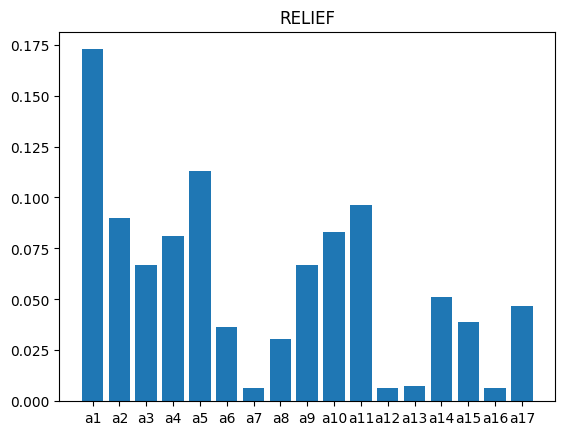

   ari & 0.01 & 0.01 & 0.07 & 0.0 & 0.0 & 0.05 & 0.0 & 0.0 & 0.0 & 0.03 & 0.04 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\
  chi2 & 0.67 & 0.0 & 0.09 & 0.04 & 0.04 & 0.0 & 0.0 & 0.03 & 0.0 & 0.01 & 0.05 & 0.0 & 0.0 & 0.01 & 0.02 & 0.0 & 0.01\\
    mi & 0.06 & 0.03 & 0.07 & 0.14 & 0.06 & 0.02 & 0.02 & 0.14 & 0.01 & 0.07 & 0.05 & 0.03 & 0.07 & 0.05 & 0.11 & 0.02 & 0.03\\
relief & 0.17 & 0.09 & 0.07 & 0.08 & 0.11 & 0.04 & 0.01 & 0.03 & 0.07 & 0.08 & 0.1 & 0.01 & 0.01 & 0.05 & 0.04 & 0.01 & 0.05\\
1-monks-1.csv
****INFORMATION ON INITIAL DATA *******
dataset: datasets-tested/1-monks-1.csv size: 432 dimension: 6
345


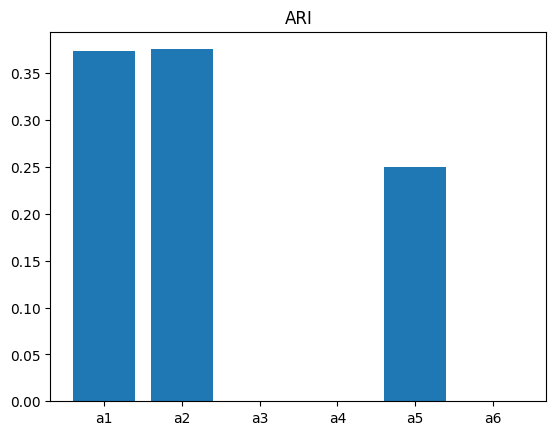

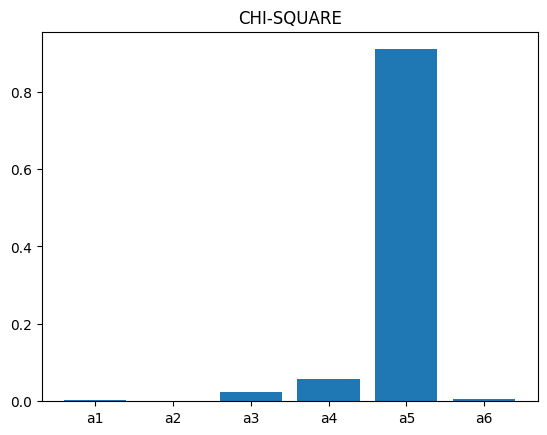

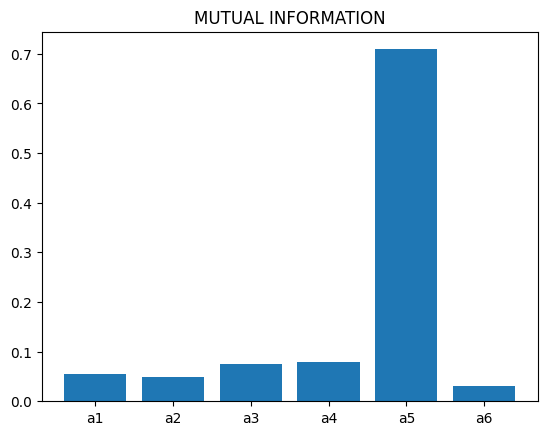

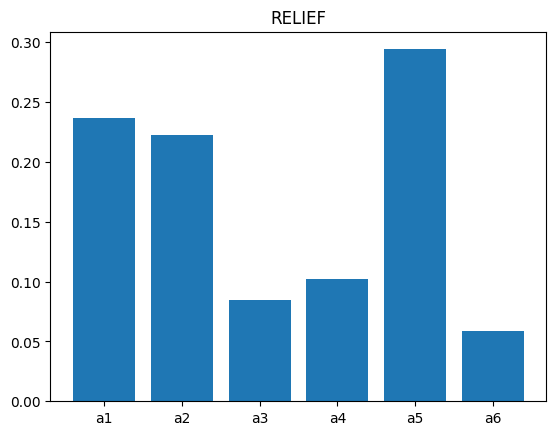

   ari & 0.37 & 0.38 & 0.0 & 0.0 & 0.25 & 0.0\\
  chi2 & 0.0 & 0.0 & 0.02 & 0.06 & 0.91 & 0.01\\
    mi & 0.05 & 0.05 & 0.08 & 0.08 & 0.71 & 0.03\\
relief & 0.24 & 0.22 & 0.08 & 0.1 & 0.29 & 0.06\\
2-monks-2.csv
****INFORMATION ON INITIAL DATA *******
dataset: datasets-tested/2-monks-2.csv size: 601 dimension: 6
480


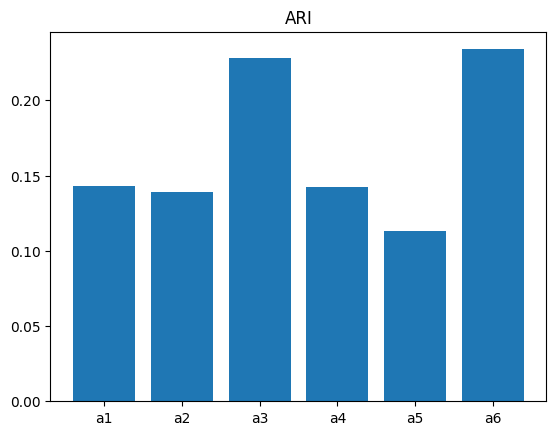

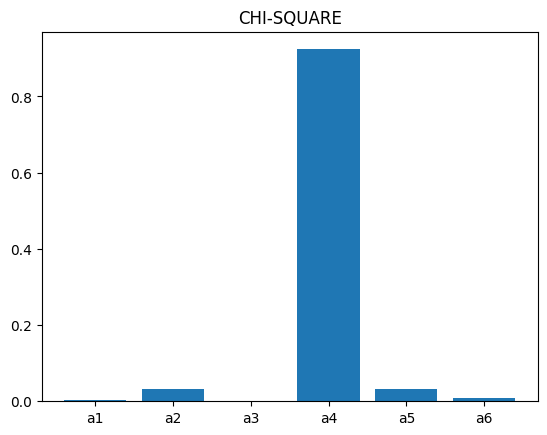

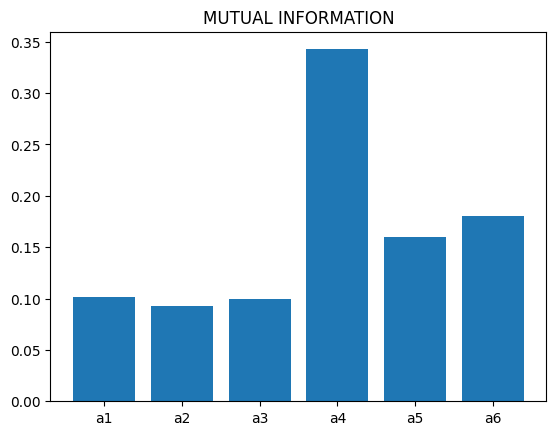

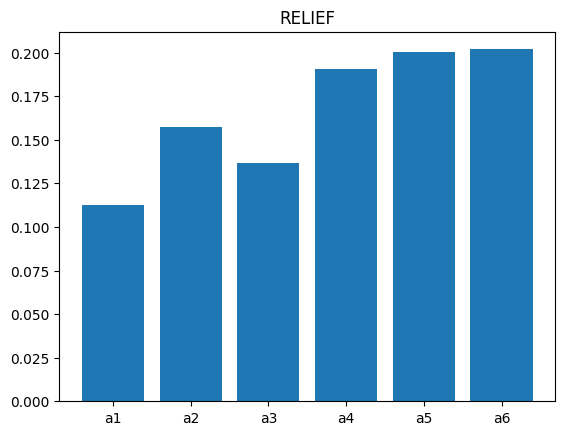

   ari & 0.14 & 0.14 & 0.23 & 0.14 & 0.11 & 0.23\\
  chi2 & 0.0 & 0.03 & 0.0 & 0.92 & 0.03 & 0.01\\
    mi & 0.1 & 0.09 & 0.1 & 0.34 & 0.16 & 0.18\\
relief & 0.11 & 0.16 & 0.14 & 0.19 & 0.2 & 0.2\\
4-breast-cancer.csv
****INFORMATION ON INITIAL DATA *******
dataset: datasets-tested/4-breast-cancer.csv size: 277 dimension: 9
221


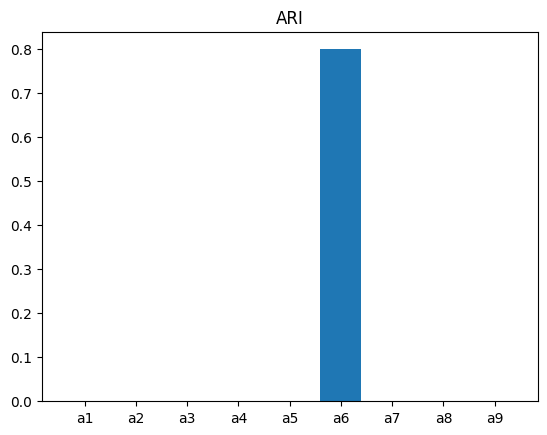

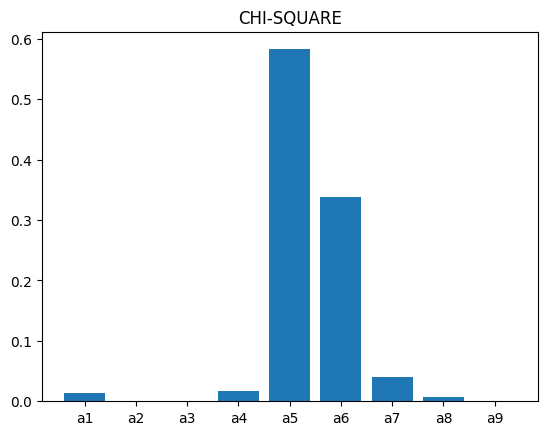

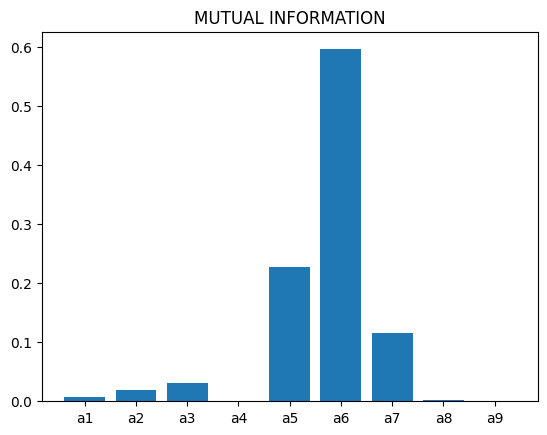

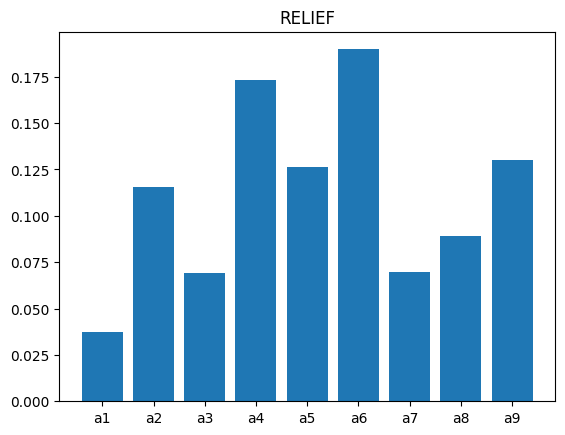

   ari & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.8 & 0.0 & 0.0 & 0.0\\
  chi2 & 0.01 & 0.0 & 0.0 & 0.02 & 0.58 & 0.34 & 0.04 & 0.01 & 0.0\\
    mi & 0.01 & 0.02 & 0.03 & 0.0 & 0.23 & 0.6 & 0.12 & 0.0 & 0.0\\
relief & 0.04 & 0.12 & 0.07 & 0.17 & 0.13 & 0.19 & 0.07 & 0.09 & 0.13\\
7-mushroom.csv
****INFORMATION ON INITIAL DATA *******
dataset: datasets-tested/7-mushroom.csv size: 5644 dimension: 22
4515


In [ ]:
number_of_test = 10
sample_ratio   = 0.8   #THERE IS AN ISSUE HERE AS I DO NOT UNDERSTAND TRAIN/TEST SAMPLE_RATIO

tested_folder="datasets-tested/"
for filename in os.listdir(tested_folder):
    print(filename)
    if filename==".DS_Store":
        continue
    compare_score_on_dataset(tested_folder+filename,number_of_test,sample_ratio)

## ACTION 11: Comparing feature relevance score effectiveness on logistic regression

In [ ]:
def test_binary_dataset(filename,k): #comparing accuracies by running logistic regression on k best features
    dataset, X, y, dimension = load_dataset(filename)
    print("data shape:",X.shape, "dimension", dimension,"nb of best features:",k)
    FOLDS=2
    list_of_attributes=[]
    for i in range(dimension):
        list_of_attributes.append(i)
    acc_baseline_all_features=baseline_for_binary_with_all(X, y,FOLDS) #10 fold cross valid
    list_of_accuracy_ars=[]
    list_of_accuracy_chi2=[]
    list_of_accuracy_mi=[]
    list_of_accuracy_relief=[]
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
    for train, test in skf.split(X,y):
        #print("****************")
        X_train_chi2, X_test_chi2, _ = select_k_features_chi2(X[train], y[train], X[test], k)
        X_train_mi, X_test_mi, _ = select_k_features_mi(X[train], y[train], X[test], k)
        r = relief.Relief(n_features=k)
        X_train_relief = r.fit_transform(X[train], y[train])
        X_test_relief = r.fit_transform(X[test], y[test])              
    # ARI feature selection
        #create A : list of attribute as index 0, 1, ...
        list_of_attributes=[]
        for i in range(dimension):
            list_of_attributes.append(i)
        sample_set = dataset[train]
        list_of_pairs = all_pairs(sample_set)
        ars_scores = select_features_ars(dimension,list_of_attributes,sample_set,list_of_pairs)
        s = numpy.array(ars_scores)
        sort_index = np.argsort(s)
        print(sort_index)
        print(ars_scores)
        #transform the dataset to keep only the k relevant features
        
        a=accuracy(X_train_ars,y[train],X_test_ars,y[test])
        list_of_accuracy_ars.append(a)   
    # CHI2
        a=accuracy(X_train_chi2,y[train],X_test_chi2,y[test])
        list_of_accuracy_chi2.append(a)
        #print("  chi2",a)   
    # MI 
        a=accuracy(X_train_mi,y[train],X_test_mi,y[test])
        list_of_accuracy_mi.append(a)
        #print("    mi",a)
    # RELIEF
        a=accuracy(X_train_relief,y[train],X_test_relief,y[test])
        list_of_accuracy_relief.append(a)
        #print("relief",a)
        
    acc_ars   = mean(list_of_accuracy_ars)
    acc_chi2  = mean(list_of_accuracy_chi2)
    acc_mi    = mean(list_of_accuracy_mi)
    acc_relief= mean(list_of_accuracy_relief)
    return(acc_baseline_all_features,acc_ars,acc_chi2,acc_mi,acc_relief)
    
def test_categorical_dataset(filename,k):  
    dataset, X, y, dimension = load_dataset(filename)
    print("data shape:",X.shape, "dimension", dimension,"nb of used best features:",k)
    FOLDS=10
    list_of_attributes=[]
    for i in range(dimension):
        list_of_attributes.append(i)
    acc_baseline_all_features=baseline_for_categorical_with_all(X,y,FOLDS) #10 fold cross valid
    list_of_accuracy_ars=[]
    list_of_accuracy_chi2=[]
    list_of_accuracy_mi=[]
    list_of_accuracy_relief=[]
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
    X_enc=prepare_input(X)
    y_enc=prepare_target(y)
    for train, test in skf.split(X,y):
        X_train_chi2_enc, X_test_chi2_enc, _ = select_k_features_chi2(X_enc[train], y_enc[train], X_enc[test], k)
        X_train_mi_enc, X_test_mi_enc, _ = select_k_features_mi(X_enc[train], y_enc[train], X_enc[test], k)
        r = relief.Relief(n_features=k)
        X_train_relief_enc = r.fit_transform(X_enc[train], y_enc[train])
        X_test_relief_enc = r.fit_transform(X_enc[test], y_enc[test])
    # ARS feature selection
        #create A : list of attribute as index 0, 1, ...
        list_of_attributes=[]
        for i in range(dimension):
            list_of_attributes.append(i)
        sample_set = dataset[train]
        list_of_pairs = all_pairs(sample_set)
        ars_scores = select_features_ars(dimension,list_of_attributes,sample_set,list_of_pairs)
        s = np.array(ars_scores)
        sort_index = np.argsort(s)
        sort_index=np.flipud(sort_index)
        #print("ars index",sort_index)
        #print("ars scores:",ars_scores)
        # transform the dataset to keep only the k relevant features
        X_train_ars_enc = np.delete(X_enc[train], sort_index[0:k],axis=1)
        X_test_ars_enc  = np.delete(X_enc[test],sort_index[0:k],axis=1)
        a=accuracy(X_train_ars_enc,y[train],X_test_ars_enc,y[test])
        list_of_accuracy_ars.append(a)  
    # CHI2 feature selection
        a=accuracy(X_train_chi2_enc,y_enc[train],X_test_chi2_enc,y_enc[test])
        list_of_accuracy_chi2.append(a)
    # MI feature selection
        a=accuracy(X_train_mi_enc,y_enc[train],X_test_mi_enc,y_enc[test])
        list_of_accuracy_mi.append(a)
    # RELIEF
        a=accuracy(X_train_relief_enc,y_enc[train],X_test_relief_enc,y_enc[test])
        list_of_accuracy_relief.append(a)
        
    acc_ars   = mean(list_of_accuracy_ars)
    acc_chi2  = mean(list_of_accuracy_chi2)
    acc_mi    = mean(list_of_accuracy_mi)
    acc_relief= mean(list_of_accuracy_relief)
    return(acc_baseline_all_features,acc_ars,acc_chi2,acc_mi,acc_relief)

In [ ]:
data_path="datasets-tested/"
file_to_be_tested=os.listdir(data_path)
for filename in file_to_be_tested:
    dataset = read_csv(data_path+filename, header=None)
    data = dataset.values
    dimension=data.shape[1] - 1
    
    k_list= [dimension//5, dimension//4,dimension//3, dimension//2, dimension-1]
    k_list=list(set(k_list))
    print("Tested dataset:",filename,"- dimension:",dimension," - k best dimension tested:",k_list)
    for num in k_list:
        if num>=1:
         acc_baseline_all_features,acc_ars,acc_chi2,acc_mi,acc_relief=test_categorical_dataset(data_path+filename,num)
         print("all:",acc_baseline_all_features," - ars:",acc_ars," - chi2:",acc_chi2," - mi:",acc_mi," - relief:",acc_relief)